# Emails_multiclassification

## Import des packages

In [395]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [701]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import re
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import random
import mailparser
from sklearn.metrics import classification_report # for model evaluation metrics
sys.path.insert(0, '/home/felix/code/mlerend/thetidinbox_1004/thetidinbox_1004')

## Import of labeled emails

In [668]:
emails_df = pd.DataFrame({"message" : [],
                         "category" : []})
for i in range(1,9):
    path_data = f'../../raw_data/enron/emails/txt_files_categories/all_txt_files{i}.txt'
    with open(path_data) as f:
        contents = f.read()
        emails_cat = ["Message-ID: " + email for email in contents.split("Message-ID: ") if email]
        emails_df = pd.concat([emails_df, pd.DataFrame({"message" : emails_cat,
                         "category" : int(i)})]).reset_index(drop=True)

In [660]:
# emails_df = pd.read_csv('https://raw.githubusercontent.com/brindasachi97/Enron-Email-Classification/master/combinedDS.csv')

## Import of sample of non-labeled emails

In [575]:
emails_sample_df = pd.read_csv("../../raw_data/enron/emails.csv", nrows = 3000)

## Parsing

In [541]:
def extract_date(email):
    mail = mailparser.parse_from_string(email)
    date = mail.date
    return date

def extract_sender(email):
    mail = mailparser.parse_from_string(email)
    if len(mail.from_) > 0:
        sender = mail.from_[0][1]
    else:
        sender = mail.from_
    return sender

def extract_recipients(email):
    mail = mailparser.parse_from_string(email)
    if len(mail.to) > 0:
        to = ",".join([rec[1] for rec in mail.to])
    else:
        to = mail.to
    return to

def extract_header(email):
    mail = mailparser.parse_from_string(email)
    header = mail.subject
    return header

def extract_body(email):
    mail = mailparser.parse_from_string(email)
    body = mail.body
    return body

### Parsing labeled emails

In [661]:
# emails_df_parsed = pd.DataFrame()
# emails_df_parsed["ID"] = emails_df["Message-ID:"].apply(lambda x: re.search(r'\d+',x)[0])
# emails_df_parsed["date"] = emails_df["Date:"]
# emails_df_parsed["from"] = emails_df["From:"]
# emails_df_parsed["to"] = emails_df["To:"]
# emails_df_parsed["header"] = emails_df["Subject:"]
# emails_df_parsed["body"] = emails_df["MessContents"]
# emails_df_parsed["category"] = emails_df["category"]
# emails_df_parsed.head()

In [669]:
emails_df_parsed = pd.DataFrame()
emails_df_parsed["ID"] = emails_df["message"].apply(lambda x: x[13:21])
emails_df_parsed["date"] = emails_df["message"].apply(extract_date)
emails_df_parsed["from"] = emails_df["message"].apply(extract_sender)
emails_df_parsed["to"] = emails_df["message"].apply(extract_recipients)
emails_df_parsed["header"] = emails_df["message"].apply(extract_header)
emails_df_parsed["body"] = emails_df["message"].apply(extract_body)
emails_df_parsed["category"] = emails_df["category"]
emails_df_parsed.head()

Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'mixed' not handled
Email content 'alternative' not handled
Email content 'alternative' 

,ID,date,from,to,header,body,category
0,197504.1,1999-10-18 08:47:00,steven.kean@enron.com,"mark.schroeder@enron.com,kenneth.lay@enron.com...",Translation of articles,---------------------- Forwarded by Steven J K...,1.0
1,11991339,2001-03-05 16:23:00,drew.fossum@enron.com,darrell.schoolcraft@enron.com,TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,In anticipation of potential litigation involv...,1.0
2,7106753.,2001-03-06 08:59:00,drew.fossum@enron.com,"julia.white@enron.com,steven.january@enron.com",TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,Julia and Steve--here are some questions I've ...,1.0
3,21267718,2001-03-06 19:59:00,drew.fossum@enron.com,"julia.white@enron.com,steven.january@enron.com",TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,Julia and Steve--here are some questions I've ...,1.0
4,20866019,2001-03-06 03:23:00,drew.fossum@enron.com,darrell.schoolcraft@enron.com,TW Gas Sales: PRIVILEGED AND CONFIDENTIAL ATTO...,In anticipation of potential litigation involv...,1.0


### Parsing non-labeled emails

In [663]:
emails_sample_df_parsed = pd.DataFrame()
emails_sample_df_parsed["ID"] = emails_sample_df["message"].apply(lambda x: x[13:21])
emails_sample_df_parsed["date"] = emails_sample_df["message"].apply(extract_date)
emails_sample_df_parsed["from"] = emails_sample_df["message"].apply(extract_sender)
emails_sample_df_parsed["to"] = emails_sample_df["message"].apply(extract_recipients)
emails_sample_df_parsed["header"] = emails_sample_df["message"].apply(extract_header)
emails_sample_df_parsed["body"] = emails_sample_df["message"].apply(extract_body)
emails_sample_df_parsed["category"] = -1
emails_sample_df_parsed.head()

,ID,date,from,to,header,body,category
0,18782981,2001-05-14 23:39:00,phillip.allen@enron.com,tim.belden@enron.com,,Here is our forecast\n\n,-1
1,15464986,2001-05-04 20:51:00,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,-1
2,24216240,2000-10-18 10:00:00,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,-1
3,13505866,2000-10-23 13:13:00,phillip.allen@enron.com,randall.gay@enron.com,,"Randy,\n\n Can you send me a schedule of the s...",-1
4,30922949,2000-08-31 12:07:00,phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,-1


## Concatenating the labeled and non-labeled emails

### Removing potential labeled emails in the non-labeled emails

In [670]:
ID_labeled = emails_df_parsed.ID.unique()
ID_non_labeled = emails_sample_df_parsed.ID.unique()
ID_to_delete = []
for id_email in ID_labeled:
    if id_email in ID_non_labeled:
        ID_to_delete.append(id_email)
emails_sample_df_parsed = emails_sample_df_parsed[~emails_sample_df_parsed["ID"].isin(ID_to_delete)]
emails_sample_df_parsed.shape

(2994, 7)

### Concatenating

In [671]:
emails_df_all = pd.concat([emails_df_parsed,emails_sample_df_parsed], axis=0).reset_index(drop=True)
emails_df_all.shape

(4710, 7)

## Data exploration

In [672]:
num_email_per_cat = emails_df_all[emails_df_all["category"]!=-1]["category"].value_counts().sort_index()
weight_email_per_cat = emails_df_all[emails_df_all["category"]!=-1]["category"].value_counts(normalize=True).sort_index()
num_mail_df = pd.DataFrame({"number of emails" : num_email_per_cat.values,
             "% of total" : round(weight_email_per_cat,2)}, index = num_email_per_cat.index)
num_mail_df.loc["Total"] = num_mail_df.sum()
num_mail_df

,number of emails,% of total
1.0,839.0,0.49
2.0,38.0,0.02
3.0,102.0,0.06
4.0,480.0,0.28
5.0,74.0,0.04
6.0,144.0,0.08
7.0,21.0,0.01
8.0,18.0,0.01
Total,1716.0,0.99


In [673]:
avg_length = int(emails_df_all["body"].apply(lambda x : len(x)).mean())
print(f"Le nombre moyen de mots par email est de {avg_length}")

Le nombre moyen de mots par email est de 3114


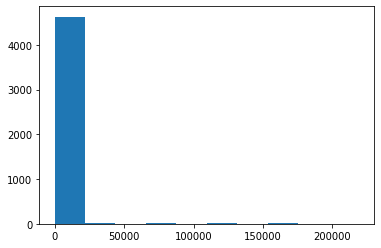

In [674]:
plt.hist(emails_df_all["body"].apply(lambda x : len(x)));

## Data cleaning

In [615]:
def clean_email(email):

    # Remove mentions
    email = re.sub(r'@\w+', '', email)
    # Remove urls
    email = re.sub(r'http\S+', ' ', email)
    # Remove digits
    email = re.sub("\d+", " ", email)
    # Remove backline character
    email = email.replace('\n', ' ')
    # Remove digits between brackets
    email = re.sub(r'<.*>', '', email)
    # Remove punctuations
    email = email.translate(str.maketrans("", "", punctuation))
    email = email.lower()
    # Remove some keyword
    elements_to_drop = ['Message-ID:', 'Date:', 'From:', 'To:', 'Subject:', 'Cc:', 'Mime-Version:',
     'Content-Type:', 'Content-Transfer-Encoding:', 'Bcc:', 'X-From:', 'X-To:', 'X-cc:', 'X-bcc:',
     'X-Folder:', 'X-Origin:', 'X-FileName:', 'cc', '\t', '--', 'Sent', ' --', '-', '/', '\n', 'Re:', 'FW:']
    for element in elements_to_drop:
        email = email.replace(element, '')

    return email

In [675]:
# emails_df_m_cleaned = emails_df_m_cleaned.loc[emails_df_m[name_col_email].notna()]
# emails_df_m_cleaned[name_col_email] = emails_df_m_cleaned[name_col_email].apply(clean_email)

emails_df_all_cleaned = emails_df_all.loc[emails_df_all["body"].notna()]
emails_df_all_cleaned[name_col_email] = emails_df_all_cleaned["body"].apply(clean_email)

## Stopwords removal

Removing English stopwords

In [181]:
def stopword_removal(email):

    stop_words = set(stopwords.words('english')) 

    email = email.split()
    filtered_sentence = ""

    for w in email: 
        if w not in stop_words: 
            filtered_sentence = filtered_sentence + w +" "

    return filtered_sentence

In [676]:
emails_df_all_cleaned["body"] = emails_df_all_cleaned["body"].apply(stopword_removal)

## Tokenizing

Transforming string into a list of words

In [677]:
emails_df_all_cleaned["body"] = emails_df_all_cleaned["body"].apply(word_tokenize)

## Lemmatizing

Replacing each word by its root (ex: 'Working' ==> 'Work')

In [678]:
def lemmatizing(email):
    
    # 1 - Lemmating the verbs
    verb_lemmatized = [                  
    WordNetLemmatizer().lemmatize(word, pos = "v") # v --> verbs
    for word in email   
    ]

    # 2 - Lemmatizing the nouns
    noun_lemmatized = [                 
    WordNetLemmatizer().lemmatize(word, pos = "n") # n --> nouns
    for word in verb_lemmatized
    ]
    
    return noun_lemmatized

In [679]:
emails_df_all_cleaned["body"] = emails_df_all_cleaned["body"].apply(lemmatizing)

Removing empty message contents after preprocessing :

In [680]:
emails_df_all_cleaned = emails_df_all_cleaned[emails_df_all_cleaned["body"].map(lambda d: len(d)) > 0]

Converting list messages into string

In [681]:
emails_df_all_cleaned["body"] = emails_df_all_cleaned["body"].apply(lambda x: " ".join(x))

## Example

In [685]:
random_email_num = random.randint(0,len(emails_df_all_cleaned))
random_email_num

3122

### Before cleaning

In [686]:
emails_df_all.loc[random_email_num,"body"]

'Dear phillip,\n\n\nThis e-mail is automated notification of the availability of your\ncurrent Natural Gas Intelligence Newsletter(s). Please use your\nusername of "pallen" and your password to access\n\n       NGI\'s Weekly Gas Price Index\n\n       Natural Gas Intelligence, the Weekly Newsletter\n\nhttp://intelligencepress.com/subscribers/index.html\n\nIf you have forgotten your password please visit\n  http://intelligencepress.com/password.html\nand we will send it to you.\n\nIf you would like to stop receiving e-mail notifications when your\npublications are available, please reply to this message with\nREMOVE E-MAIL in the subject line.\n\nThank you for your subscription.\n\nFor information about other Intelligence Press products and services,\nincluding maps and glossaries visit our web site at\nhttp://intelligencepress.com or call toll-free (800) 427-5747.\n\nALL RIGHTS RESERVED. (c) 2001, Intelligence Press, Inc.\n---\n           '

### After cleaning

In [687]:
emails_df_all_cleaned.loc[random_email_num,"body"]

'dear phillip email automate notification availability current natural gas intelligence newsletter please use username pallen password aess ngis weekly gas price index natural gas intelligence weekly newsletter forget password please visit send would like stop receive email notification publication available please reply message remove email subject line thank subscription information intelligence press product service include map glossary visit web site call tollfree right reserve c intelligence press inc'

## Export csv

In [198]:
emails_df_all_cleaned.to_csv("emails_df_cleaned.csv")

## Initial model

### Evaluating a model based on the 1700 emails labelled

In [690]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.semi_supervised import SelfTrainingClassifier # for Semi-Supervised learning

# Considering only labeled emails
emails_df_all_cleaned_train = emails_df_all_cleaned[emails_df_all_cleaned["category"]!=-1]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(emails_df_all_cleaned_train["body"], emails_df_all_cleaned_train["category"], test_size=0.2)

# Vectorizer
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Model
clf = SVC(probability=True)
clf.fit(X_train_counts, y_train)
y_pred = clf.predict(X_test_counts)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.4868035190615836


In [691]:
y_pred_proba = clf.predict_proba(X_test_counts)
name_col_cat = ["cat_" + str(i) for i in range(1,9)]
y_pred_proba_df = pd.DataFrame(y_pred_proba, columns = name_col_cat).reset_index(drop=True)
X_y_pred = pd.DataFrame({"body_test" : X_test,
            "category_pred" : y_pred}).reset_index(drop=True)
pred_df = pd.concat([X_y_pred, y_pred_proba_df], axis=1)

threshold = 0.8
pred_df["proba_cat"] = pred_df[name_col_cat].max(axis=1)
# pred_df["keep_cat_pred"] = pred_df["proba_cat"].apply(lambda x: True if x> threshold else False)
pred_df.head(3)

,body_test,category_pred,cat_1,cat_2,cat_3,cat_4,cat_5,cat_6,cat_7,cat_8,proba_cat
0,attach draft agenda discus irwin show joskow a...,1.0,0.264988,0.024466,0.051992,0.512055,0.023395,0.099701,0.012809,0.010594,0.512055
1,call rob wall see attend carol ann brown commu...,1.0,0.157483,0.022899,0.048843,0.688827,0.017988,0.041677,0.012569,0.009716,0.688827
2,advice much esteem spouse would like express g...,1.0,0.244468,0.026990,0.054902,0.530355,0.049583,0.069028,0.014229,0.010445,0.530355


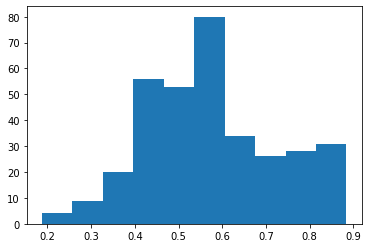

In [692]:
plt.hist(pred_df["proba_cat"]);

## Labelling emails based on initial model

### Labelling

In [694]:
# Train-test split on the whole dataset, with labeled and non labeled emails
X_train, X_test, y_train, y_test = train_test_split(emails_df_all_cleaned["body"], 
                                                    emails_df_all_cleaned["category"], 
                                                    test_size=0.2)

# Vectorizer
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Model
clf = SVC(probability=True)

# Specify Self-Training model parameters
self_training_model = SelfTrainingClassifier(base_estimator=clf, # An estimator object implementing fit and predict_proba.
                                             threshold=0.7, # default=0.75, The decision threshold for use with criterion='threshold'. Should be in [0, 1).
                                             criterion='threshold', # {‘threshold’, ‘k_best’}, default=’threshold’, The selection criterion used to select which labels to add to the training set. If 'threshold', pseudo-labels with prediction probabilities above threshold are added to the dataset. If 'k_best', the k_best pseudo-labels with highest prediction probabilities are added to the dataset.
                                             #k_best=50, # default=10, The amount of samples to add in each iteration. Only used when criterion='k_best'.
                                             max_iter=10, # default=10, Maximum number of iterations allowed. Should be greater than or equal to 0. If it is None, the classifier will continue to predict labels until no new pseudo-labels are added, or all unlabeled samples have been labeled.
                                             verbose=True # default=False, Verbosity prints some information after each iteration
                                            )
# Fit the model
clf_ST = self_training_model.fit(X_train_counts, y_train)

End of iteration 1, added 66 new labels.
End of iteration 2, added 10 new labels.
End of iteration 3, added 7 new labels.
End of iteration 4, added 55 new labels.
End of iteration 5, added 41 new labels.
End of iteration 6, added 1 new labels.
End of iteration 7, added 57 new labels.
End of iteration 8, added 2 new labels.
End of iteration 9, added 2 new labels.
End of iteration 10, added 169 new labels.

---------- Self Training Model - Summary ----------
Base Estimator:  SVC(probability=True)
Classes:  [1. 2. 3. 4. 5. 6. 7. 8.]
Transduction Labels:  [-1. -1. -1. ... -1. -1. -1.]
Number of Features:  28007


AttributeError: 'SelfTrainingClassifier' object has no attribute 'feature_names_in_'

In [702]:
########## Step 3 - Model Evaluation ########## 
print('')
print('---------- Self Training Model - Summary ----------')
print('Base Estimator: ', clf_ST.base_estimator_)
print('Classes: ', clf_ST.classes_)
print('Transduction Labels: ', clf_ST.transduction_)
#print('Iteration When Sample Was Labeled: ', clf_ST.labeled_iter_)
print('Number of Features: ', clf_ST.n_features_in_)
# print('Feature Names: ', clf_ST.feature_names_in_)

print('Number of Iterations: ', clf_ST.n_iter_)
print('Termination Condition: ', clf_ST.termination_condition_)
print('')

print('---------- Self Training Model - Evaluation on Test Data ----------')
accuracy_score_ST = clf_ST.score(X_test_counts, y_test)
print('Accuracy Score: ', accuracy_score_ST)
# Look at classification report to evaluate the model
print(classification_report(y_test, clf_ST.predict(X_test_counts)))


---------- Self Training Model - Summary ----------
Base Estimator:  SVC(probability=True)
Classes:  [1. 2. 3. 4. 5. 6. 7. 8.]
Transduction Labels:  [-1. -1. -1. ... -1. -1. -1.]
Number of Features:  28007
Number of Iterations:  10
Termination Condition:  max_iter

---------- Self Training Model - Evaluation on Test Data ----------
Accuracy Score:  0.20106951871657755
              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       584
         1.0       0.56      0.55      0.56       167
         2.0       0.00      0.00      0.00         7
         3.0       0.00      0.00      0.00        25
         4.0       0.12      0.91      0.22       106
         5.0       0.00      0.00      0.00         7
         6.0       0.00      0.00      0.00        29
         7.0       0.00      0.00      0.00         4
         8.0       0.00      0.00      0.00         6

    accuracy                           0.20       935
   macro avg       0.08      0.1

/home/felix/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/felix/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/felix/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf